## Import packages

In [17]:
import sys
sys.path.append('/home/eym16/anaconda3/lib/python3.6/site-packages')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import bisect
import pandas as pd

## Device configuration

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.device_count())

0


## Data generation

In [19]:
import random

#frames generator class
class Frame_generator(object):

    def __init__(self, dim, train_samples=4):
#         self.array = array
        self.dim = dim
        self.train_samples = train_samples
        self.zeros = np.zeros((dim, dim))
#         self.itemindex = self.itemindex_fun
#         self.indices = self.datasets_indices
#         self.frame = self.frame(x=array)
        
#     def itemindex_fun(self,value):
#         itemindex = np.where(self.array==value)
#         return itemindex
    
#     def datasets_indices(self, train_samples):
#         indices = np.arange(len(self.itemindex(1)[0]))
#         one_indices =  random.sample(list(indices), train_samples)
#         return(one_indices)

    #using self.definitions for the functions didn't work out
    #forward part doesn't work
    def frame(self, loc1, loc2):
        res = np.copy(self.zeros)
        for i,j in zip(loc1,loc2):
#             print('i:', i)
#             print('j:', j)
            res[i][j]+=1
            if i==0 and j==0:
                res[i][j+1]+=1
                res[i+1][j]+=1
                res[i+1][j+1]+=1
            elif i==0 and j==self.dim-1:
                res[i][j-1]+=1
                res[i+1][j-1]+=1
                res[i+1][j]+=1
            elif i==self.dim-1 and j==0:
                res[i-1][j]+=1
                res[i-1][j+1]+=1
                res[i][j+1]+=1
            elif i==self.dim-1 and j==self.dim-1:
                res[i-1][j]+=1
                res[i-1][j-1]+=1
                res[i][j-1]+=1
            elif i==0:
                res[i][j-1]+=1
                res[i][j+1]+=1
                res[i+1][j-1]+=1
                res[i+1][j]+=1
                res[i+1][j+1]+=1
            elif i==self.dim-1:
                res[i][j-1]+=1
                res[i][j+1]+=1
                res[i-1][j-1]+=1
                res[i-1][j]+=1
                res[i-1][j+1]+=1
            elif j==0:
                res[i-1][j]+=1
                res[i+1][j]+=1
                res[i-1][j+1]+=1
                res[i][j+1]+=1
                res[i+1][j+1]+=1
            elif j==self.dim-1:
                res[i-1][j]+=1
                res[i+1][j]+=1
                res[i-1][j-1]+=1
                res[i][j-1]+=1
                res[i+1][j-1]+=1
            else:
                res[i-1][j-1]+=1
                res[i-1][j]+=1
                res[i-1][j+1]+=1
                res[i][j-1]+=1
                res[i][j+1]+=1
                res[i+1][j-1]+=1
                res[i+1][j]+=1
                res[i+1][j+1]+=1

        return(res)
    
    #produce dataset
    def frames(self, n_frames, loc1, loc2):
        frames = np.empty((n_frames, self.dim, self.dim))
        for i in range(n_frames):
            loc1_tmp = loc1[loc1[:,i].nonzero()[0],i]
            loc2_tmp = loc2[loc2[:,i].nonzero()[0],i]
            intervals = np.arange(0,1,1/self.dim)
            loc1_index = []
            loc2_index = []
#             print(loc1_tmp.shape)
            for n in range(loc1_tmp.shape[0]):
#                 print(loc1_tmp)
                loc1_index.append(bisect.bisect_left(intervals, loc1_tmp[n])-1)
                loc2_index.append(bisect.bisect_left(intervals, loc2_tmp[n])-1)
            frames[i][:][:]=self.frame(loc1_index, loc2_index)
        return frames

# final image generator
def final_image(dim, n_frames):
    n = np.random.poisson(lam=10, size=1)
    loc_mat = np.random.rand(n[0],2)
    intervals = np.arange(0,1,1/dim)
    loc1 = []
    loc2 = []
    for n in range(loc_mat.shape[0]):
        loc1.append(bisect.bisect_left(intervals, loc_mat[n,0])-1)
        loc2.append(bisect.bisect_left(intervals, loc_mat[n,1])-1)
    x = np.zeros((dim,dim))
    for i,j in zip(loc1,loc2):
        x[i][j] += 1
    #generate location matrices
#     print(loc_mat[:,0].shape)
    binom = np.random.binomial(n=1,p=min(1,4/loc_mat.shape[0]),size=(loc_mat.shape[0],n_frames))
#     print(binom.shape)
    loc1 = np.multiply(np.reshape(loc_mat[:,0],(loc_mat.shape[0],-1)),binom)
    loc2 = np.multiply(np.reshape(loc_mat[:,1],(loc_mat.shape[0],-1)),binom)
    loc1 = loc1[loc1[:,:].nonzero()[0],:]
    loc2 = loc2[loc2[:,:].nonzero()[0],:]
    return(x, loc1, loc2)


# images generator function
def frames_data_fun(n_images, n_frames, dim):
    labels = np.zeros((n_images, 2, dim, dim))
    data = np.empty((n_images, n_frames, dim, dim))
    for n in range(n_images):
        x, loc1, loc2 = final_image(dim, n_frames)
        tmp = Frame_generator(dim)
        frames = tmp.frames(n_frames=n_frames, loc1=loc1, loc2=loc2)
        labels[n][1][:][:]=x
        m = (x!=0)
        labels[n][0][:][:]=1*m
        data[n][:][:][:]=frames
    return(labels, data)

# call images generator function
# 1000 images, 10000 frames, 100X100 dimension
res = frames_data_fun(n_images=500, n_frames=1000, dim=10)
labels = res[0]
data = res[1]

print(data.shape)
# print('data frame:', data[2,3,:,:])
# print('lable:', labels[2,:,:])

(500, 1000, 10, 10)


## Hyper parameters

In [20]:
# Hyper-parameters
num_epochs = 100
learning_rate = 0.001
channel_dim = data.shape[1]
input_dim=data.shape[2]
data_samples = len(data)
train_samples = round(0.8*data_samples)
conv_layers0 = 16

# # Image preprocessing modules
# transform = transforms.Compose([
#     transforms.Pad(4),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32),
# transforms.ToTensor()])

## Train and test datasets

In [21]:
import random

# Data loader
def datasets_indices(data_samples, train_samples):    
    indices = np.arange(data_samples)
    #print(indices)
    train_indices =  random.sample(list(indices), train_samples)
    #print(train_indices)
    test_indices = list(set(list(indices))-set(train_indices))
    #print(test_indices)
    return(train_indices, test_indices)

indices = datasets_indices(data_samples, train_samples)
train_loader = data[indices[0],:,:,:]
train_labels = labels[indices[0],:,:]
test_loader = data[indices[1],:,:,:]
test_labels = labels[indices[1],:,:]

np.save('test_data', test_loader)
np.save('test_labels', test_labels)

# define mini-batch
train_loader = torch.utils.data.DataLoader(dataset=train_loader,
                                           batch_size=32,shuffle=False)
train_labels = torch.utils.data.DataLoader(dataset=train_labels,
                                           batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_loader,
                                           batch_size=32,shuffle=False)
test_labels = torch.utils.data.DataLoader(dataset=test_labels,
                                           batch_size=32,shuffle=False)

# datasets shapes
#print(train_loader.shape)
#print(test_loader.shape)

## Define a model
ResNet 18 modified version (terminal fully connected layer is replaced with another convolution layer).

In [22]:
epsilon = 10**(-4)

# 3x3 convolution

def conv3x3(in_channels, out_channels, stride=1, input_dim=input_dim):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=np.ceil((input_dim*stride-input_dim-stride+3)/2), bias=True)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        #print("block conv1 size:", out.shape)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        #print("block conv2 size:", out.shape)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        #print("block size:", out.shape)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = conv_layers0
        self.conv = conv3x3(channel_dim, conv_layers0)
        self.bn = nn.BatchNorm2d(conv_layers0)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, conv_layers0, layers[0])
        self.layer2 = self.make_layer(block, conv_layers0*2, layers[0], 2)
        self.layer3 = self.make_layer(block, conv_layers0*4, layers[1], 2)
        self.conv_final = nn.Conv2d(conv_layers0*4, 2, kernel_size=1, 
                     stride=1, padding=0, bias=True)
        self.out_act = nn.Sigmoid()
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.conv_final(out)
        out0 = torch.unsqueeze(out[:,0,:,:],1)
        out1 = torch.unsqueeze(out[:,1,:,:],1)
        #replace sigmoid by ReLu
#         out = self.out_act(out)
        out0 = self.out_act(out0)
        out0 = out0.clamp(min=epsilon, max=1-epsilon)
        out1 = self.relu(out1)
        out = torch.cat((out0,out1),1)
        #print("net size:", out.shape)
        return out

## Run the model
 - Loss function: absolute deviation
 - Train the model on the train data.
 - Test the model on the test data and report model accuracy.

In [23]:
# epsilon = 10**(-6)

# Check if multiple GPUs are available, and if so parallelize the computations
model = ResNet(ResidualBlock, [2, 2, 2, 2]).double().to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

#loss function
class Loss(torch.nn.Module):

    def __init__(self):
        super(Loss,self).__init__()

    def forward(self,x,y):
#         print('x shape:', x.shape)
#         print(x[0,:,:])
        loss_layer0 = -(y[:,0,:,:]*torch.log(x[:,0,:,:])*10+(1-y[:,0,:,:])*torch.log(1-x[:,0,:,:]))
#         print(loss_layer0)
        loss_layer0 = torch.sum(loss_layer0)
        loss_layer1 = 0
        for image in range(x.shape[0]):
            for i in range(x.shape[2]):
                for j in range(x.shape[3]):
                    if y[image,0,i,j]==1:
                        loss_layer1+=abs(y[image,1,i,j]-x[image,1,i,j])/(x.shape[2]^2)
        totloss = loss_layer0+loss_layer1
        return totloss

# Loss and optimizer
criterion = Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

## Load and test the model

In [57]:
model.load_state_dict(torch.load('resnet.ckpt'))

# Test the model (test data)
print('################')
print('test data results')
def test_results(threshold):
    print(threshold)
    model.eval()
    res = []
    for j in threshold:
        print('j:', j)
        with torch.no_grad():
            correct = 0
            semi_correct = 0
            total = 0
            total_ones = 0
            total_zeros = 0
            correct_ones = 0
            correct_zeros = 0
            for i, (images,labels) in enumerate(zip(test_loader, test_labels)):
                images = images.to(device)
                labels = labels.to(device)
                #print(images.shape)
                outputs = model(images.view(-1,channel_dim,input_dim,input_dim))
                outputs = outputs.view(-1,2,input_dim,input_dim)
                #print('outputs', (outputs>j))
                predicted = ((outputs>j)*1).double()
        #         print('predicted shape:', predicted.shape)
        #         print('labels shape:', labels.shape)
        #         print(labels.shape[0])
                total += labels.shape[0]*input_dim*input_dim
                #print('predicted:', predicted[:,0,:,:])
                #print('labels:', labels[:,0,:,:])
                m = (labels[:,0,:,:]>0)*(predicted[:,0,:,:] == labels[:,0,:,:])
                correct += (predicted[:,0,:,:] == labels[:,0,:,:]).sum().item()-(m*(predicted[:,1,:,:] != labels[:,1,:,:])).sum().item()
                semi_correct += (predicted[:,0,:,:] == labels[:,0,:,:]).sum().item()
                total_ones +=  (labels[:,0,:,:]==1).sum().item()
                total_zeros += (labels[:,0,:,:]==0).sum().item()
                correct_ones += ((predicted[:,0,:,:] == labels[:,0,:,:])*(labels[:,0,:,:]==1)).sum().item()
                correct_zeros += ((predicted[:,0,:,:] == labels[:,0,:,:])*(labels[:,0,:,:]==0)).sum().item()
            res.append([correct_ones,total_ones,correct_zeros,total_zeros])
        print('shape:', len(res))
        res_out = pd.DataFrame(data=res, columns=['correct_ones','total_ones','correct_zeros','total_zeros'])
        print(correct_ones, total_ones, correct_zeros, total_zeros)
        print('accuracy:', correct/total*100, '%')
        print('semi_correct:', semi_correct/total*100, '%')
        print('correct ones:', correct_ones/total_ones*100, '%')
        print('correct zeros:', correct_zeros/total_zeros*100, '%')

        with open('out.txt', 'a') as f:
            print('\n', 'Accuracy of the model on the test images: {} %'.format(100 * correct / total), file=f, sep='')
    return(res_out)

threshold = np.arange(0,1.05,0.05)

res = test_results(threshold)
print('res:\n', res, type(res))

print(res.shape)
res.index = threshold
print(res)

################
test data results
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
j: 0.0
shape: 1
912 912 0 9088
accuracy: 8.72 %
semi_correct: 9.120000000000001 %
correct ones: 100.0 %
correct zeros: 0.0 %
j: 0.05
shape: 2
783 912 8236 9088
accuracy: 89.79 %
semi_correct: 90.19 %
correct ones: 85.85526315789474 %
correct zeros: 90.625 %
j: 0.1
shape: 3
768 912 8441 9088
accuracy: 91.69 %
semi_correct: 92.09 %
correct ones: 84.21052631578947 %
correct zeros: 92.88072183098592 %
j: 0.15000000000000002
shape: 4
746 912 8544 9088
accuracy: 92.5 %
semi_correct: 92.9 %
correct ones: 81.7982456140351 %
correct zeros: 94.01408450704226 %
j: 0.2
shape: 5
728 912 8624 9088
accuracy: 93.12 %
semi_correct: 93.52000000000001 %
correct ones: 79.82456140350878 %
correct zeros: 94.8943661971831 %
j: 0.25
shape: 6
721 912 8665 9088
accuracy: 93.46 %
semi_correct: 93.86 %
correct ones: 79.05701754385966 %
correct zeros: 95.34551056338029 %
j:

## Edit results table

In [61]:
res['true_positives_rate']=res.correct_ones/res.total_ones
res['false_positives_rate']=(res.total_zeros-res.correct_zeros)/res.total_zeros
print(res)

      correct_ones  total_ones  correct_zeros  total_zeros  \
0.00           912         912              0         9088   
0.05           783         912           8236         9088   
0.10           768         912           8441         9088   
0.15           746         912           8544         9088   
0.20           728         912           8624         9088   
0.25           721         912           8665         9088   
0.30           710         912           8703         9088   
0.35           704         912           8737         9088   
0.40           694         912           8764         9088   
0.45           679         912           8787         9088   
0.50           670         912           8810         9088   
0.55           660         912           8827         9088   
0.60           649         912           8848         9088   
0.65           637         912           8868         9088   
0.70           625         912           8890         9088   
0.75    

## ROC curve

0.00    0.000000
1.00    0.000000
0.95    0.527412
0.90    0.584430
0.85    0.620614
0.80    0.642544
0.75    0.663377
0.70    0.685307
0.65    0.698465
0.60    0.711623
0.55    0.723684
0.50    0.734649
0.45    0.744518
0.40    0.760965
0.35    0.771930
0.30    0.778509
0.25    0.790570
0.20    0.798246
0.15    0.817982
0.10    0.842105
0.05    0.858553
0.00    1.000000
0.00    1.000000
dtype: float64
0.00    0.000000
1.00    0.000000
0.95    0.009573
0.90    0.012984
0.85    0.015295
0.80    0.017606
0.75    0.019586
0.70    0.021787
0.65    0.024208
0.60    0.026408
0.55    0.028719
0.50    0.030590
0.45    0.033121
0.40    0.035651
0.35    0.038622
0.30    0.042364
0.25    0.046545
0.20    0.051056
0.15    0.059859
0.10    0.071193
0.05    0.093750
0.00    1.000000
0.00    1.000000
dtype: float64


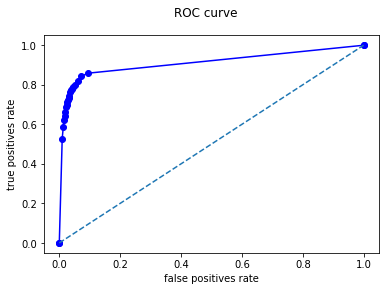

In [62]:
import matplotlib.pyplot as plt

true_positives_rate_1 = [pd.Series([0]),res.true_positives_rate[::-1],pd.Series([1])]
res_a = pd.concat(true_positives_rate_1)
print(res_a)
false_positives_rate_1 = [pd.Series([0]),res.false_positives_rate[::-1],pd.Series([1])]
res_b = pd.concat(false_positives_rate_1)
print(res_b)
plt.plot(res_b, res_a,  marker='o', color='b')
# plt.annotate('0.9', xy=(false_positives_rate_1[1], true_positives_rate_1[1]))
plt.plot([0,1],[0,1], label='identity line', linestyle='dashed')
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.suptitle('ROC curve')
plt.savefig('ROC.jpg', bbox_inches="tight")
plt.show()

## Probability histogram

torch.Size([32, 1000, 10, 10])
<class 'torch.Tensor'>
torch.Size([32, 1000, 10, 10])
<class 'torch.Tensor'>
torch.Size([32, 1000, 10, 10])
<class 'torch.Tensor'>
torch.Size([4, 1000, 10, 10])
<class 'torch.Tensor'>
torch.Size([100, 10, 10])
(10000,)


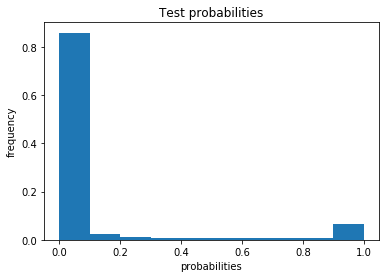

In [47]:
torch.no_grad()
probability = torch.empty(0,1,10,10)
for i, images in enumerate(test_loader):
                images = images.to(device)
                print(images.shape)
                outputs = model(images.view(-1,channel_dim,input_dim,input_dim)).float()
                probability = torch.cat((probability, outputs[:,0,:,:]),0)
                print(type(outputs))
print(probability.shape)
probability = probability.view(-1).detach().numpy()
print(probability.shape)
plt.hist(probability, weights=np.zeros_like(probability) + 1. / probability.size)
plt.title('Test probabilities')
plt.xlabel('probabilities')
plt.ylabel('frequency')
plt.savefig('pred_prob.jpg', bbox_inches="tight")
plt.show()

In [54]:
x = (probability<0.5).sum()
print(x)

9052


In [60]:
list(res.columns.values)

['correct_ones', 'total_ones', 'correct_zeros', 'total_zeros']